# COMP8221 Advanced Machine Learning

### Assignment One

In [42]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

Dataset is a list of 70,000 human faces with dimention 64 * 64 RGB images from huggingface.

URL - https://huggingface.co/datasets/Dmini/FFHQ-64x64

In [43]:
from datasets import load_dataset

from PIL import Image
import matplotlib.pyplot as plt

try:

    ds = load_dataset("Dmini/FFHQ-64x64")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


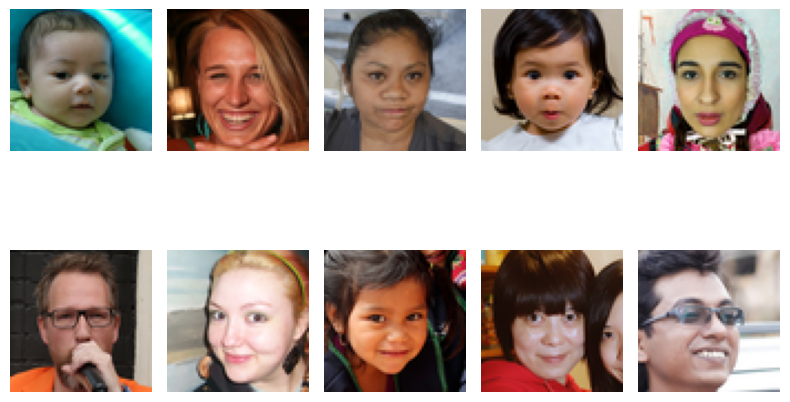

In [44]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(8, 6)) 
axes = axes.flatten() 

for i in range(10):


    image = ds['train'][i]['image'] 

    axes[i].imshow(image) 
    axes[i].axis('off') 

plt.tight_layout() 
plt.show()

In [58]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms


class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self,dataset, mode='train', likelihood_type='bernoulli'):
        if mode == 'train':
            # Training data: first 50000 samples
            self.data = dataset['train'].select(range(2000))  
        elif mode == 'val':
            # Validation data: samples 50000 to 65000
            self.data = dataset['train'].select(range(2000, 2500))  
        else:
            # Test data: remaining samples
            self.data = dataset['train'].select(range(65000, len(dataset['train']))) 
        
        self.likelihood_type = likelihood_type
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0,1] range
            #self.get_normalization()
        ])

    def get_normalization(self):
        """Returns appropriate normalization based on likelihood type"""
        if self.likelihood_type == 'bernoulli':
            # No additional normalization - ToTensor already gives [0,1]
            return transforms.Lambda(lambda x: x)
        elif self.likelihood_type == 'gaussian':
            # Standard ImageNet normalization
            return transforms.Normalize([0.5] * 3, [0.5] * 3)
        else:
            raise ValueError(f"Unsupported likelihood: {self.likelihood_type}")

    def __len__(self):
        # Return the number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get a specific sample
        image = self.data[idx]['image']  # Extract image (PIL format)
        return self.transform(image) 

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class BetaVAE_Encoder(nn.Module):
    def __init__(self, z_dim, leaky_slope=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), #(input channel , output channel, kernel, pstride, padding )
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(leaky_slope),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.LeakyReLU(leaky_slope), #output would be a (512, 4 ,4) image 
        )
        self.fc_mu = nn.Linear(512*4*4, z_dim)
        self.fc_logvar = nn.Linear(512*4*4, z_dim)

    def forward(self, x):
        h = self.conv(x).flatten(1)
        return self.fc_mu(h), self.fc_logvar(h)


In [60]:
class BetaVAE_Decoder(nn.Module):
    def __init__(self, z_dim, leaky_slope=0.2):
        super().__init__()
        self.fc = nn.Linear(z_dim, 512*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.LeakyReLU(leaky_slope),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.LeakyReLU(leaky_slope),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.LeakyReLU(leaky_slope),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 512, 4, 4)
        return self.deconv(h)


In [61]:
import math

def log_normal_diag(x, mu, log_var):
    return -0.5 * (log_var + ((x - mu) ** 2) / log_var.exp() + math.log(2 * math.pi)).sum(dim=1)

def log_bernoulli(x, recon_x):
    return (x * torch.log(recon_x + 1e-6) + (1 - x) * torch.log(1 - recon_x + 1e-6)).sum(dim=[1, 2, 3])

class Prior:
    def log_prob(self, z):
        # Assume standard normal prior
        return -0.5 * (z ** 2 + math.log(2 * math.pi)).sum(dim=1)

    def sample(self, batch_size, z_dim):
        return torch.randn(batch_size, z_dim)

In [62]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Bernoulli, Categorical

class BetaVAE(nn.Module):
    def __init__(self, z_dim=128, likelihood_type='bernoulli', beta=1.0, leaky_slope=0.2):
        super().__init__()
        self.encoder = BetaVAE_Encoder(z_dim, leaky_slope)
        self.decoder = BetaVAE_Decoder(z_dim, leaky_slope)
        
        self.z_dim = z_dim
        self.likelihood_type = likelihood_type.lower()
        self.beta = beta
        
        # Register prior as buffer (moves with model.to(device))
        self.register_buffer("prior_mean", torch.zeros(z_dim))
        self.register_buffer("prior_cov", torch.eye(z_dim))
        self.prior = MultivariateNormal(self.prior_mean, self.prior_cov)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, reduction='avg'):
        # Encode
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        
        # Decode
        decoder_output = self.decoder(z)
        
        # Reconstruction error
        if self.likelihood_type == 'bernoulli':
        # Apply sigmoid to constrain to [0,1]
            probs = torch.sigmoid(decoder_output)
            RE = F.binary_cross_entropy(
                probs,  # Now guaranteed to be [0,1]
                x,      # Already [0,1] from dataset
                reduction='none'
            ).view(x.size(0), -1).sum(dim=1)
        elif self.likelihood_type == 'gaussian':
            RE = F.mse_loss(
                decoder_output, x, reduction='none'
            ).view(x.size(0), -1).sum(dim=1)
        elif self.likelihood_type == 'categorical':
            RE = -Categorical(logits=decoder_output).log_prob(x.long()).sum(dim=1)
        else:
            raise ValueError(f"Unsupported likelihood: {self.likelihood_type}")

        # KL divergence
        KL = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1).sum(dim=1)
        
        
        return (RE + self.beta * KL).mean() if reduction == 'avg' else (RE + self.beta * KL).sum()

    def sample(self, num_samples, return_logits=False):
        with torch.no_grad():
            z = self.prior.sample((num_samples,))
            logits = self.decoder(z)
            if return_logits:
                return logits
            return torch.sigmoid(logits) if self.likelihood_type == 'bernoulli' else logits

    def reconstruct(self, x):
        with torch.no_grad():
            mu, _ = self.encoder(x)
            return self.decoder(mu)

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from typing import Optional, Union, List

def evaluation(
    test_loader,
    name: Optional[str] = None,
    model_best: Optional[torch.nn.Module] = None,
    epoch: Optional[Union[int, str]] = None,
    device: str = 'auto'
) -> float:

    if model_best is None:
        if name is None:
            raise ValueError("requires model name or bestmodel")
        model_best = torch.load(f'{name}.model', map_location='cpu')
    
    # Device handling
    if device == 'auto':
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_best = model_best.to(device)
    model_best.eval()
    
    # Evaluation loop
    total_loss = 0.
    total_samples = 0
    
    with torch.no_grad():
        for test_batch in test_loader:
            test_batch = test_batch.to(device)
            batch_loss = model_best(test_batch, reduction='sum')
            total_loss += batch_loss.item()
            total_samples += test_batch.size(0)
    
    avg_loss = total_loss / total_samples
    
    # Logging
    if epoch is None:
        print(f'[FINAL EVAL] Loss: {avg_loss:.4f}')
    else:
        print(f'[Epoch {epoch}] Val loss: {avg_loss:.4f}')
    
    return avg_loss


def visualize_samples(
    name: str,
    test_loader,
    sample_type: str = 'real',
    num_samples: int = 16,
    model: Optional[torch.nn.Module] = None,
    save_format: str = 'pdf'
):

    assert sample_type in ['real', 'generated'], "Invalid sample type"
    
    grid_size = int(np.sqrt(num_samples))
    assert grid_size * grid_size == num_samples, "num_samples should be perfect square"
    
    if sample_type == 'real':
        samples = next(iter(test_loader))[:num_samples].cpu()
    else:
        if model is None:
            model = torch.load(f'{name}.model', map_location='cpu')
        model.eval()
        with torch.no_grad():
            samples = model.sample(num_samples).cpu()
    
    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        img = samples[i].permute(1, 2, 0).numpy()
        
        # Print both gray scale and RGB images
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
            
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{name}_{sample_type}_samples.{save_format}', bbox_inches='tight')
    plt.close()


def plot_training_curve(
    name: str,
    metrics: List[float],
    metric_name: str = 'nll',
    save_format: str = 'pdf'
):

    plt.figure(figsize=(8, 5))
    plt.plot(metrics, linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.upper())
    plt.title(f'{metric_name.upper()} Training Curve')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{name}_{metric_name}_curve.{save_format}', bbox_inches='tight')
    plt.close()


In [78]:
def training(
    name: str,
    max_patience: int,
    num_epochs: int,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    training_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    eval_every: int = 1,
    save_checkpoints: bool = True,
    dequantization: bool = False,
    grad_clip: Optional[float] = None,
    device: str = 'auto'
) -> np.ndarray:
    
    # Device setup
    if device == 'auto':
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Training state
    nll_val = []
    best_nll = float('inf')
    patience = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        num_batches = 0
        
        for batch in training_loader:
            batch = batch.to(device)
            
            # Dequantization if enabled
            if dequantization:
                batch = batch + torch.rand_like(batch) / 256.0
            
            # Forward pass and loss computation
            loss = model(batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping if specified
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            optimizer.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        # Log training progress
        avg_train_loss = epoch_train_loss / num_batches
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}')
        
        # Validation
        if (epoch + 1) % eval_every == 0:
            val_loss = evaluation(
                val_loader,
                model_best=model,
                epoch=epoch+1,
                device=device
            )
            nll_val.append(val_loss)
            
            # Check for improvement
            if val_loss < best_nll:
                print(f'[Epoch {epoch+1}] Validation loss improved from {best_nll:.4f} to {val_loss:.4f}')
                best_nll = val_loss
                patience = 0
                
                # Save best model
                if save_checkpoints:
                    torch.save(model.state_dict(), f'{name}_best.model')
                    print('Best model saved!')
                    
                    # Generate samples
                    visualize_samples(
                        name,
                        val_loader,
                        sample_type='generated',
                        model=model
                    )
            else:
                patience += 1
                print(f'[Epoch {epoch+1}] No improvement. Patience: {patience}/{max_patience}')
                
            # Early stopping check
            if patience >= max_patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model at the end
    if save_checkpoints and os.path.exists(f'{name}_best.model'):
        model.load_state_dict(torch.load(f'{name}_best.model'))
    
    # Final evaluation
    final_loss = evaluation(val_loader, model_best=model, epoch='final', device=device)
    print(f'Training complete. Final validation loss: {final_loss:.4f}')
    
    return np.array(nll_val)

In [83]:
import os
train_data = Digits(ds,mode='train' ,likelihood_type='bernoulli' )
val_data = Digits(ds,mode='val',likelihood_type='bernoulli')
test_data = Digits(ds,mode='test',likelihood_type='bernoulli')

training_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

result_dir = 'BETA_VAE_Output/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

In [107]:
import torch
import torch.nn as nn
from pytorch_model_summary import summary

config = {
    'input_shape': (3, 64, 64),  
    'latent_dim': 16,             
    'hidden_dim': 256,       
    'learning_rate': 1e-3,
    'num_epochs': 300,
    'max_patience': 10,
    'likelihood_type': 'bernoulli',  # 'bernoulli' or 'categorical'
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

model = BetaVAE(z_dim=config['latent_dim'],likelihood_type=config['likelihood_type']).to(config['device'])



print("\nENCODER DETAILS:")
print(summary(model.encoder,torch.zeros(1, *config['input_shape']).to(config['device']),show_input=True))

print("\nDECODER DETAILS:")
print(summary(
    model.decoder,
    torch.zeros(1, config['latent_dim']).to(config['device']),
    show_input=True
))


ENCODER DETAILS:
------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1       [1, 3, 64, 64]           3,136           3,136
       LeakyReLU-2      [1, 64, 32, 32]               0               0
          Conv2d-3      [1, 64, 32, 32]         131,200         131,200
       LeakyReLU-4     [1, 128, 16, 16]               0               0
          Conv2d-5     [1, 128, 16, 16]         524,544         524,544
       LeakyReLU-6       [1, 256, 8, 8]               0               0
          Conv2d-7       [1, 256, 8, 8]       2,097,664       2,097,664
       LeakyReLU-8       [1, 512, 4, 4]               0               0
          Linear-9            [1, 8192]         131,088         131,088
         Linear-10            [1, 8192]         131,088         131,088
Total params: 3,018,720
Trainable params: 3,018,720
Non-trainable params: 0
-----------------------------------------

In [81]:
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=config["learning_rate"])

In [82]:
#nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
 #                      training_loader=training_loader, val_loader=val_loader)


training_results = training(
    name=os.path.join(result_dir, name),
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
    
    # Training Parameters
    num_epochs=config['num_epochs'],
    max_patience=config['max_patience'],
    
)

# Post-Training Analysis
print(f"\nTraining completed. Best validation loss: {min(training_results):.4f}")

# Save Final Model and Training Curves
torch.save(model.state_dict(), os.path.join(result_dir, f'{name}_final.pth'))


Epoch 1/300 | Train Loss: 8278.8333
[Epoch 1] Val loss: 7970.1692
[Epoch 1] Validation loss improved from inf to 7970.1692
Best model saved!
Epoch 2/300 | Train Loss: 7728.6974
[Epoch 2] Val loss: 7577.4029
[Epoch 2] Validation loss improved from 7970.1692 to 7577.4029
Best model saved!
Epoch 3/300 | Train Loss: 7476.4170
[Epoch 3] Val loss: 7399.0559
[Epoch 3] Validation loss improved from 7577.4029 to 7399.0559
Best model saved!
Epoch 4/300 | Train Loss: 7324.4911
[Epoch 4] Val loss: 7303.7005
[Epoch 4] Validation loss improved from 7399.0559 to 7303.7005
Best model saved!
Epoch 5/300 | Train Loss: 7258.2497
[Epoch 5] Val loss: 7246.9933
[Epoch 5] Validation loss improved from 7303.7005 to 7246.9933
Best model saved!
Epoch 6/300 | Train Loss: 7206.3775
[Epoch 6] Val loss: 7206.3456
[Epoch 6] Validation loss improved from 7246.9933 to 7206.3456
Best model saved!
Epoch 7/300 | Train Loss: 7169.6594
[Epoch 7] Val loss: 7180.5364
[Epoch 7] Validation loss improved from 7206.3456 to 7180.

TypeError: plot_training_curve() got an unexpected keyword argument 'save_path'

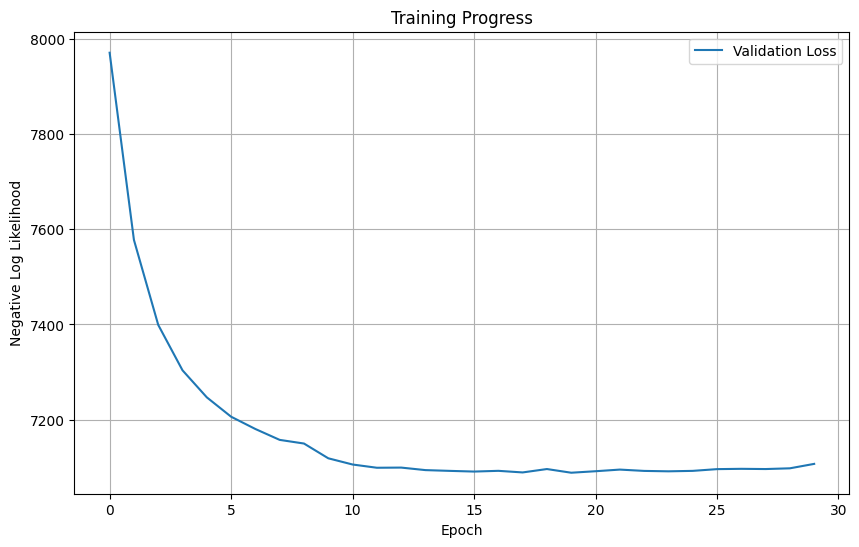

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(training_results, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.title('Training Progress')
plt.legend()
plt.grid(True)


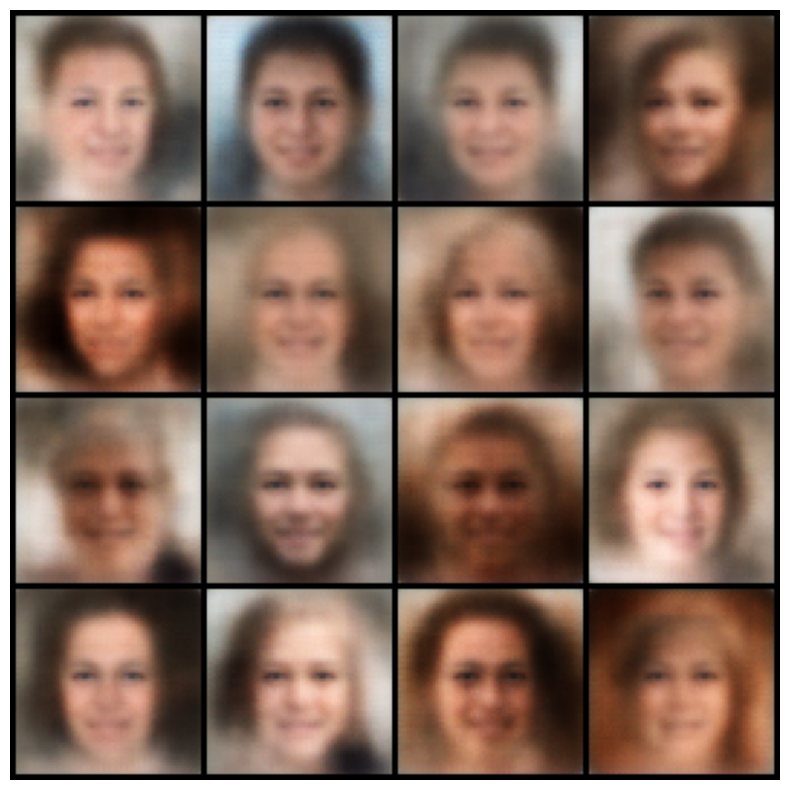

In [101]:

from torchvision.utils import make_grid

# 1. Load your trained model STATE DICT
model_path = result_dir+'/vae_best.model'
state_dict = torch.load(model_path, map_location='cpu')

# 2. Recreate your model architecture first
model = BetaVAE(z_dim=16, likelihood_type='bernoulli')  # Use your actual initialization parameters

# 3. Load the state dict into the model
model.load_state_dict(state_dict)
model.eval()  # Now this will work

# 4. Generate random samples
num_samples = 16
with torch.no_grad():
    z = torch.randn(num_samples, model.z_dim)
    samples = model.decoder(z)
    if model.likelihood_type == 'bernoulli':
        samples = torch.sigmoid(samples)

# 5. Display the grid
grid = make_grid(samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()